# Demonstrate the Aggregated Prediction Methods

In [1]:
import helper
import aggregated_predict as ap
import pandas as pd
import joblib
import time
import warnings
warnings.simplefilter('ignore')

## 1. Testing of each model and demonstration of model aggregated prediction methods

Sensor Model 1 Prediction Results:
-----------------------------
Accuracy : 0.934380299343803
Precision: 0.934387737755483
Recall   : 0.934380299343803
F1 Score : 0.9343839597552155
-----------------------------

Sensor Model 2 Prediction Results:
-----------------------------
Accuracy : 0.9362972793629728
Precision: 0.9363665236973329
Recall   : 0.9362972793629728
F1 Score : 0.9363275498823399
-----------------------------

Sensor Model 3 Prediction Results:
-----------------------------
Accuracy : 0.9335938460026051
Precision: 0.9336405067569034
Recall   : 0.9335938460026051
F1 Score : 0.9336152022800123
-----------------------------

Network Model Prediction Results:
-----------------------------
Accuracy : 0.9975669099756691
Precision: 0.9975696400783128
Recall   : 0.9975669099756691
F1 Score : 0.9975674104604447
-----------------------------


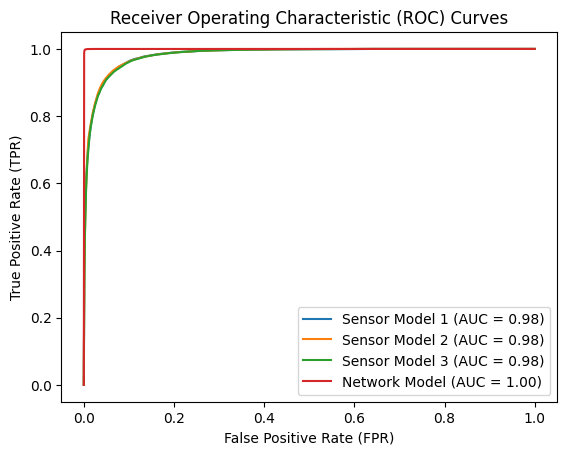

In [2]:
# Load the testing set
sensor_test, network_test = helper.load_test_set()

# Load the models
sensor_models = ['./received_models/client_1.joblib', './received_models/client_2.joblib', './received_models/client_3.joblib']
network_model = './received_models/global_model.joblib'

# Test models 
models_predictions, models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=sensor_test,
    global_model=network_model,
    network_test=network_test,
)

In [3]:
# Load network testing set, set the weights
y_test = network_test.iloc[:, -1]
model_weights = [0.2, 0.2, 0.2, 0.4]

In [4]:
print(f"Aggregated Prediction by Score:")
score = ap.aggregate_predict_by_score(
    models_predictions=models_predictions,
    models_metrics=models_metrics,
    models_weights=model_weights)
helper.get_metrics(y_test, score, printout=True)

Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.9869006365356731
Precision: 0.9869129716090983
Recall   : 0.9869006365356731
F1 Score : 0.9869047771873588
-----------------------------


(0.9869006365356731,
 0.9869129716090983,
 0.9869006365356731,
 0.9869047771873588)

In [5]:
print(f"Aggregated Prediction by Vote:")
vote = ap.aggregate_predict_by_vote(models_predictions=models_predictions)
helper.get_metrics(y_test, vote, printout=True)

Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.9322667059893337
Precision: 0.9422524211007809
Recall   : 0.9322667059893337
F1 Score : 0.932965126453714
-----------------------------



(0.9322667059893337, 0.9422524211007809, 0.9322667059893337, 0.932965126453714)

## 2. Simulation of Intrusion Detection in Wireless Sensor Networks

Once the WSN simulation starts, the sensors in the nodes will collect new sensing data, these data need to pass the validation of the local models first. The data that passes the validation will be sent to the server and the data that does not pass will be discarded. Once the server receives the sensed data, it will validate the sensor data and the network traffic generated by the transmitted data by aggregated prediction method to give the final validation result. If the data passes the validation, the data is saved, otherwise, the data is discarded.

In [6]:
sensor_test['target'].value_counts()

target
0    24751
1    15938
Name: count, dtype: int64

In [7]:
# Select 10000 equally distributed samples from the testing set
s0 = sensor_test[sensor_test['target'] == 0].sample(10000)
s1 = sensor_test[sensor_test['target'] == 1].sample(10000)
sampled_sensor_data = pd.concat([s0, s1])
sampled_network_data = network_test.loc[sampled_sensor_data.index]

sampled_sensor_data = sampled_sensor_data.reset_index(drop=True)
sampled_network_data = sampled_network_data.reset_index(drop=True)

print(sampled_sensor_data['target'].value_counts())
print(sampled_network_data['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64
target
0    10000
1    10000
Name: count, dtype: int64


In [8]:
# Use Client 1 as an example
client_1_model = joblib.load('./received_models/client_1.joblib')
test_X = sampled_sensor_data.iloc[:, :-1]
test_y = sampled_sensor_data.iloc[:, -1]
client_1_predict = client_1_model.predict(test_X)
helper.get_metrics(test_y, client_1_predict, printout=True)

-----------------------------
Accuracy : 0.93175
Precision: 0.9320815318385645
Recall   : 0.93175
F1 Score : 0.9317369056025749
-----------------------------


(0.93175, 0.9320815318385645, 0.93175, 0.9317369056025749)

In [9]:
client_1_predict_df = pd.DataFrame(client_1_predict, columns=['Pred'])
client_1_predict_df['Pred'].value_counts()

Pred
0    10277
1     9723
Name: count, dtype: int64

In [10]:
# Client 1 will test the sensor data locally, only those that pass will be sent to the server
# Drop false data, target = 1
rows_to_keep = client_1_predict_df['Pred'] == 0
filtered_sensor_data = sampled_sensor_data[rows_to_keep]
filtered_network_data = sampled_network_data[rows_to_keep]

print(filtered_sensor_data['target'].value_counts())
print(filtered_network_data['target'].value_counts())

target
0    9456
1     821
Name: count, dtype: int64
target
0    9456
1     821
Name: count, dtype: int64


Sensor Model 1 Prediction Results:
-----------------------------
Accuracy : 0.9201128734066362
Precision: 0.8466076998086164
Recall   : 0.9201128734066362
F1 Score : 0.8818311793374705
-----------------------------

Sensor Model 2 Prediction Results:
-----------------------------
Accuracy : 0.9403522428724336
Precision: 0.9411254834494841
Recall   : 0.9403522428724336
F1 Score : 0.9407279096337197
-----------------------------

Sensor Model 3 Prediction Results:
-----------------------------
Accuracy : 0.9422983360902987
Precision: 0.9441246177878194
Recall   : 0.9422983360902987
F1 Score : 0.9431492465668438
-----------------------------


Network Model Prediction Results:
-----------------------------
Accuracy : 0.9972754694949888
Precision: 0.997355848048854
Recall   : 0.9972754694949888
F1 Score : 0.9972948284405675
-----------------------------


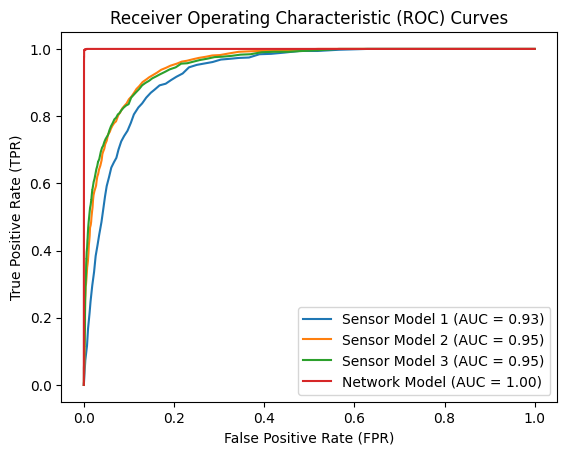

In [11]:
# Test Client 1 data using all models
new_models_predictions, new_models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=filtered_sensor_data,
    global_model=network_model,
    network_test=filtered_network_data,
)

In [12]:
# Load Client 1 network testing set, set the weights
new_y_test = filtered_network_data.iloc[:, -1]
new_model_weights = [0.4, 0.05, 0.05, 0.5]

In [13]:
print(f"Client 1 Aggregated Prediction by Score:")
start_time = time.time()

new_score = ap.aggregate_predict_by_score(
    models_predictions=new_models_predictions,
    models_metrics=new_models_metrics,
    models_weights=new_model_weights)

end_time = time.time()
rows = len(new_models_predictions[0])
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_score, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.9972754694949888
Precision: 0.997355848048854
Recall   : 0.9972754694949888
F1 Score : 0.9972948284405675
-----------------------------


Time spent predicting 10277 pieces of data: 0.0 second, average time spent: 0.0 seconds.


In [14]:
print(f"Client 1 Aggregated Prediction by Vote:")
start_time = time.time()

new_vote = ap.aggregate_predict_by_vote(models_predictions=new_models_predictions)

end_time = time.time()
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_vote, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.9450228665953099
Precision: 0.9674341799962116
Recall   : 0.9450228665953099
F1 Score : 0.9512135227055922
-----------------------------


Time spent predicting 10277 pieces of data: 0.006459474563598633 second, average time spent: 6.285369819595829e-07 seconds.
